## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: NLP Classification: Subreddit Pepsi vs Coca-Cola | Part 3: Vectorizer Peformance

---

[README](../README.md) | [Part 1: EDA](01_EDA.ipynb)  | [Part 2: Vectorizer](02_Vectorizer.ipynb) | **Part 3: Vectorizer Performance** | [Part 4: Model Tuning](04_Model_Tuning.ipynb)

---

### Introduction
In this section, we will analyze the results of various parameter combinations for three models—Naive Bayes and XGBoost—from [Part 2: Vectorizer](02_Vectorizer.ipynb). The primary objective of this analysis is to evaluate how different parameter configurations impact each model's accuracy score. By systematically examining the performance across these models, we aim to identify the key parameters that drive model accuracy and understand the trade-offs associated with different settings. This analysis will provide valuable insights into optimizing model performance and selecting the most effective hyperparameter configurations.

### Import

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Data Preparation
Some parameter combinations result in `NaN` accuracy scores during cross-validation, often due to issues like data imbalance, computational errors (e.g., division by zero), or small datasets that prevent the model from learning effectively. To ensure a reliable analysis, we will exclude these `NaN` results and focus only on the valid parameter combinations that produce meaningful accuracy scores.

For this analysis, we will use the following columns: 
- `param_classifier`: The classifier model used (e.g., Naive Bayes, AdaBoost and XGBoost)
- `param_vectorizer`: The type of vectorizer applied (e.g., CountVectorizer, TfidfVectorizer)
- `param_vectorizer__tokenizer`: The tokenizer function used for text tokenization 
- `param_vectorizer__max_features`: The maximum number of features for the vectorizer; possible values include 3000, 5000, or None
- `param_vectorizer__ngram_range`: The range of n-grams used for tokenization; options include unigrams or both unigrams and bigrams
- `param_vectorizer__min_df`: The minimum document frequency for terms to be considered in the vectorizer; options are 2 or 3
- `param_vectorizer__max_df`: The maximum document frequency for terms to be considered in the vectorizer; options are 0.8 or 0.9
- `mean_train_accuracy`: The mean accuracy score calculated from the training data
- `mean_test_accuracy`: The mean accuracy score calculated from the testing data

In [28]:
df1 = pd.read_csv('../data/cv_results_nb.csv')                       # Load Data Naive Bayes Performance
df2 = pd.read_csv('../data/cv_results_xgb.csv')                      # Load Data XGBoost Performance 
df3 = pd.read_csv('../data/cv_results_ada.csv')                      # Load Data AdaBoost Performance 
df4 = pd.read_csv('../data/cv_results_gb.csv')                       # Load Data GradientBoost Performance 
# Check shape
df1.shape, df2.shape, df3.shape, df4.shape                                                      

((288, 73), (288, 73), (288, 73), (288, 73))

In [29]:
# Concatenate 3 DataFrames into single DataFrame.
# Note that all DataFrames have same structures.
df = pd.concat([df1, df2, df3, df4], axis = 0, ignore_index = True)

# Check
df.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_vectorizer,param_vectorizer__max_df,param_vectorizer__max_features,param_vectorizer__min_df,...,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1
0,0,6.482064,0.374552,2.387187,0.530890,MultinomialNB(),CountVectorizer(token_pattern=None),0.8,3000.0,2,...,0.656966,0.020020,186,0.808511,0.802022,0.809483,0.790186,0.801695,0.802379,0.006890
1,1,6.820330,0.470872,3.450289,1.457087,MultinomialNB(),CountVectorizer(token_pattern=None),0.8,3000.0,2,...,0.668008,0.027307,147,0.821963,0.812242,0.825581,0.805042,0.814381,0.815842,0.007267
2,2,15.779505,1.088593,4.674823,1.028505,MultinomialNB(),CountVectorizer(token_pattern=None),0.8,3000.0,2,...,0.652557,0.014684,215,0.801370,0.775300,0.798291,0.792230,0.792929,0.792024,0.009024
3,3,10.980268,3.065498,3.471096,1.715701,MultinomialNB(),CountVectorizer(token_pattern=None),0.8,3000.0,2,...,0.668405,0.025770,139,0.811400,0.787521,0.816807,0.797320,0.811305,0.804871,0.010812
4,4,20.976396,2.336415,0.463699,0.927397,MultinomialNB(),CountVectorizer(token_pattern=None),0.8,3000.0,2,...,NaN,NaN,287,0.799658,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Focus Columns
columns = ['param_classifier' 
           , 'param_vectorizer'
           , 'param_vectorizer__tokenizer' 
           , 'param_vectorizer__max_features' 
           , 'param_vectorizer__ngram_range' 
           , 'param_vectorizer__min_df' 
           , 'param_vectorizer__max_df'
           , 'mean_train_accuracy' 
           , 'mean_test_accuracy'
           , 'mean_train_f1'
           , 'mean_test_f1'
          ]

df = df[columns]

In [31]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False).head()

param_vectorizer__max_features    384
mean_train_accuracy                 5
mean_test_accuracy                  5
mean_train_f1                       5
mean_test_f1                        5
dtype: int64

In [32]:
# Map Classifiers Name
def map_classifier_name(classifier_name):
    if 'AdaBoostClassifier' in classifier_name:
        return 'AdaBoost'
    elif 'XGBClassifier' in classifier_name:
        return 'XGBoost'
    elif 'MultinomialNB' in classifier_name:
        return 'Naive Bayes'
    else:
        return 'GradientBoost'  # In case there are any other classifiers

df['param_classifier'] = df['param_classifier'].apply(map_classifier_name)

In [33]:
# Tokenizer name
tokenizers = ['lem_only', 'lem_stop', 'lower_only', 'lower_stop', 'stem_only', 'stem_stop']

for word in tokenizers:
    df['param_vectorizer__tokenizer'] = np.where(
        df['param_vectorizer__tokenizer'].str.contains(word, na=False), 
        word, 
        df['param_vectorizer__tokenizer']
    )

In [34]:
df['param_vectorizer__tokenizer'].value_counts()

param_vectorizer__tokenizer
lower_only    192
lower_stop    192
stem_only     192
stem_stop     192
lem_only      192
lem_stop      192
Name: count, dtype: int64

In [35]:
# Drop rows that mean_train_accuracy or mean_test_accuracy is NaN
df = df.dropna(subset=['mean_train_accuracy','mean_test_accuracy'])

### Vectorizer and Tokenizer Performance
- We compare performance by analyzing the effect of each parameter while keeping the classifiers at their default settings.
- Summary of Key Effects:
    - Vectorizer Effect: TfidfVectorizer generally outperforms CountVectorizer across all classifiers, especially for XGBoost and GradientBoost.
    - Lemmatization and stemming work well in AdaBoost. Retaining stopwords improves training accuracy in Gradient Boost and XGBoost, while removing stopwords leads to better testing accuracy. 
- Other Parameters
  - Naive Bayes is the only model that is affected by n-gram_range and min_df. Using bigrams and setting min_df = 2 yields higher accuracy.

In [48]:
dx = df_grouped = df.groupby(['param_classifier', 'param_vectorizer'])[['mean_train_accuracy', 'mean_test_accuracy']] \
    .mean() \
    .mul(100) \
    .astype(int) \
    .reset_index()

dx

,param_classifier,param_vectorizer,mean_train_accuracy,mean_test_accuracy
0,AdaBoost,CountVectorizer(token_pattern=None),64,62
1,AdaBoost,TfidfVectorizer(token_pattern=None),65,62
2,GradientBoost,CountVectorizer(token_pattern=None),81,68
3,GradientBoost,TfidfVectorizer(token_pattern=None),85,66
4,Naive Bayes,CountVectorizer(token_pattern=None),80,67
5,Naive Bayes,TfidfVectorizer(token_pattern=None),87,67
6,XGBoost,CountVectorizer(token_pattern=None),89,66
7,XGBoost,TfidfVectorizer(token_pattern=None),93,64


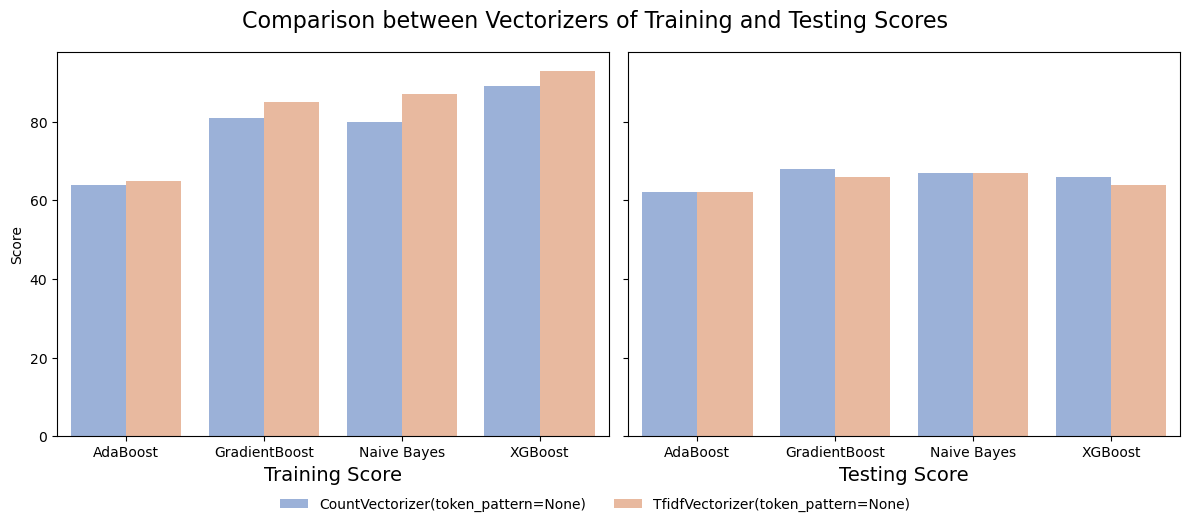

In [37]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

# Training Score
sns.barplot(data = dx
            , x = 'param_classifier'
            , y = 'mean_train_accuracy'
            , hue = 'param_vectorizer'
            , palette = 'muted'
            , alpha = 0.6
            , ax = axes[0]
           )
axes[0].set_title('')
axes[0].set_xlabel('Training Score', fontsize = 14)
axes[0].set_ylabel('Score')
axes[0].legend().remove()

# Testing Score
sns.barplot(data = dx
            , x = 'param_classifier'
            , y = 'mean_test_accuracy'
            , hue = 'param_vectorizer'
            , palette = 'muted'
            , alpha = 0.6
            , ax = axes[1]
           )
axes[1].set_title('')
axes[1].set_xlabel('Testing Score', fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend().remove()

# Create shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles
           , labels
           , loc = 'center'
           , bbox_to_anchor = (0.5, -0.01)
           , ncol = len(labels)
           , frameon = False
          )

# Adjust layout and display
fig.suptitle('Comparison between Vectorizers of Training and Testing Scores', fontsize=16)
plt.tight_layout()
#plt.savefig('../images/vectorizer_performance.png', dpi = 300, bbox_inches = 'tight')
plt.show();

In [38]:
dy = df.groupby(['param_classifier','param_vectorizer','param_vectorizer__tokenizer'])\
[['mean_train_accuracy', 'mean_test_accuracy']]\
.mean()\
.mul(100)\
.reset_index()

dy

,param_classifier,param_vectorizer,param_vectorizer__tokenizer,mean_train_accuracy,mean_test_accuracy
0,AdaBoost,CountVectorizer(token_pattern=None),lem_only,64.094012,62.260231
1,AdaBoost,CountVectorizer(token_pattern=None),lem_stop,64.096788,62.643617
2,AdaBoost,CountVectorizer(token_pattern=None),lower_only,62.939208,60.344722
3,AdaBoost,CountVectorizer(token_pattern=None),lower_stop,62.452376,60.344722
4,AdaBoost,CountVectorizer(token_pattern=None),stem_only,65.629454,64.015384
5,AdaBoost,CountVectorizer(token_pattern=None),stem_stop,65.645416,64.239026
6,AdaBoost,TfidfVectorizer(token_pattern=None),lem_only,64.703269,61.646097
7,AdaBoost,TfidfVectorizer(token_pattern=None),lem_stop,64.212350,62.063416
8,AdaBoost,TfidfVectorizer(token_pattern=None),lower_only,64.176465,60.897943
9,AdaBoost,TfidfVectorizer(token_pattern=None),lower_stop,64.081946,61.744453


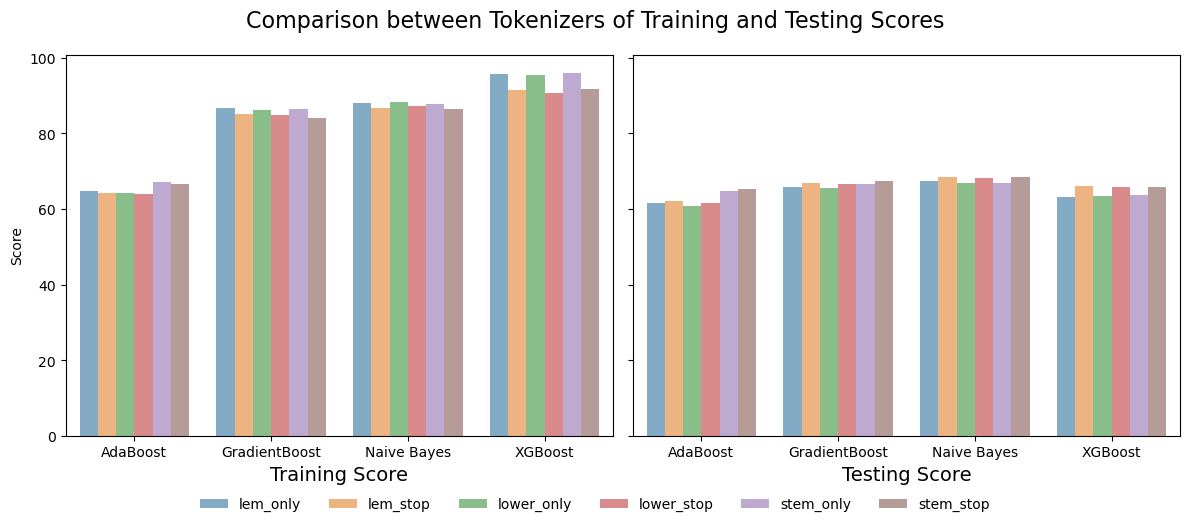

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

# Training Score
sns.barplot(data = dy[dy['param_vectorizer'] == 'TfidfVectorizer(token_pattern=None)']
            , x = 'param_classifier'
            , y = 'mean_train_accuracy'
            , hue = 'param_vectorizer__tokenizer'
            #, palette = 'muted'
            , alpha = 0.6
            , ax = axes[0]
           )
axes[0].set_title('')
axes[0].set_xlabel('Training Score', fontsize = 14)
axes[0].set_ylabel('Score')
axes[0].legend().remove()

# Testing Score
sns.barplot(data = dy[dy['param_vectorizer'] == 'TfidfVectorizer(token_pattern=None)']
            , x = 'param_classifier'
            , y = 'mean_test_accuracy'
            , hue = 'param_vectorizer__tokenizer'
            #, palette = 'muted'
            , alpha = 0.6
            , ax = axes[1]
           )
axes[1].set_title('')
axes[1].set_xlabel('Testing Score', fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend().remove()

# Create shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles
           , labels
           , loc = 'center'
           , bbox_to_anchor = (0.5, -0.01)
           , ncol = len(labels)
           , frameon = False
          )

# Adjust layout and display
fig.suptitle('Comparison between Tokenizers of Training and Testing Scores', fontsize=16)
plt.tight_layout()
#plt.savefig('../images/tokenizer_performance.png', dpi = 300, bbox_inches = 'tight')
plt.show();

### Tuning Vectorizer

In [40]:
df\
.groupby(['param_classifier','param_vectorizer','param_vectorizer__max_features'], dropna = False)\
[['mean_train_accuracy', 'mean_test_accuracy']].mean().mul(100).astype(int)

mean_train_accuracy  \
param_classifier param_vectorizer                    param_vectorizer__max_features                        
AdaBoost         CountVectorizer(token_pattern=None) 3000.0                                           64   
                                                     5000.0                                           64   
                                                     NaN                                              64   
                 TfidfVectorizer(token_pattern=None) 3000.0                                           65   
                                                     5000.0                                           65   
                                                     NaN                                              65   
GradientBoost    CountVectorizer(token_pattern=None) 3000.0                                           81   
                                                     5000.0                                           81   
                                                     NaN                                              81   
                 TfidfVectorizer(token_pattern=None) 3000.0                                           85   
                                                     5000.0                                           85   
                                                     NaN                                              85   
Naive Bayes      CountVectorizer(token_pattern=None) 3000.0                                           80   
                                                     5000.0                                           81   
                                                     NaN                                              81   
                 TfidfVectorizer(token_pattern=None) 3000.0                                           86   
                                                     5000.0                                           87   
                                                     NaN                                              87   
XGBoost          CountVectorizer(token_pattern=None) 3000.0                                           89   
                                                     5000.0                                           89   
                                                     NaN                                              89   
                 TfidfVectorizer(token_pattern=None) 3000.0                                           93   
                                                     5000.0                                           93   
                                                     NaN                                              93   

                                                                                     mean_test_accuracy  
param_classifier param_vectorizer                    param_vectorizer__max_features                      
AdaBoost         CountVectorizer(token_pattern=None) 3000.0                                          62  
                                                     5000.0                                          62  
                                                     NaN                                             62  
                 TfidfVectorizer(token_pattern=None) 3000.0                                          62  
                                                     5000.0                                          62  
                                                     NaN                                             62  
GradientBoost    CountVectorizer(token_pattern=None) 3000.0                                          69  
                                                     5000.0                                          68  
                                                     NaN                                             69  
                 TfidfVectorizer(token_pattern=None) 3000.0                                          66  
    

In [41]:
df\
.groupby(['param_classifier','param_vectorizer','param_vectorizer__ngram_range'], dropna = False)\
[['mean_train_accuracy', 'mean_test_accuracy']].mean().mul(100).astype(int)

mean_train_accuracy  \
param_classifier param_vectorizer                    param_vectorizer__ngram_range                        
AdaBoost         CountVectorizer(token_pattern=None) (1, 1)                                          64   
                                                     (1, 2)                                          64   
                 TfidfVectorizer(token_pattern=None) (1, 1)                                          65   
                                                     (1, 2)                                          65   
GradientBoost    CountVectorizer(token_pattern=None) (1, 1)                                          80   
                                                     (1, 2)                                          81   
                 TfidfVectorizer(token_pattern=None) (1, 1)                                          85   
                                                     (1, 2)                                          85   
Naive Bayes      CountVectorizer(token_pattern=None) (1, 1)                                          79   
                                                     (1, 2)                                          82   
                 TfidfVectorizer(token_pattern=None) (1, 1)                                          86   
                                                     (1, 2)                                          88   
XGBoost          CountVectorizer(token_pattern=None) (1, 1)                                          89   
                                                     (1, 2)                                          90   
                 TfidfVectorizer(token_pattern=None) (1, 1)                                          93   
                                                     (1, 2)                                          93   

                                                                                    mean_test_accuracy  
param_classifier param_vectorizer                    param_vectorizer__ngram_range                      
AdaBoost         CountVectorizer(token_pattern=None) (1, 1)                                         62  
                                                     (1, 2)                                         62  
                 TfidfVectorizer(token_pattern=None) (1, 1)                                         62  
                                                     (1, 2)                                         62  
GradientBoost    CountVectorizer(token_pattern=None) (1, 1)                                         69  
                                                     (1, 2)                                         68  
                 TfidfVectorizer(token_pattern=None) (1, 1)                                         66  
                                                     (1, 2)                                         66  
Naive Bayes      CountVectorizer(token_pattern=None) (1, 1)                                         67  
                                                     (1, 2)                                         66  
                 TfidfVectorizer(token_pattern=None) (1, 1)                                         68  
                                                     (1, 2)                                         67  
XGBoost          CountVectorizer(token_pattern=None) (1, 1)                                         66  
                                                     (1, 2)                                         66  
                 TfidfVectorizer(token_pattern=None) (1, 1)                                         64  
                                                     (1, 2)                                         64

In [42]:
df\
.groupby(['param_classifier','param_vectorizer','param_vectorizer__min_df'], dropna = False)\
[['mean_train_accuracy', 'mean_test_accuracy']].mean().mul(100).astype(int)

mean_train_accuracy  \
param_classifier param_vectorizer                    param_vectorizer__min_df                        
AdaBoost         CountVectorizer(token_pattern=None) 2                                          64   
                                                     3                                          64   
                 TfidfVectorizer(token_pattern=None) 2                                          65   
                                                     3                                          65   
GradientBoost    CountVectorizer(token_pattern=None) 2                                          81   
                                                     3                                          81   
                 TfidfVectorizer(token_pattern=None) 2                                          85   
                                                     3                                          85   
Naive Bayes      CountVectorizer(token_pattern=None) 2                                          82   
                                                     3                                          79   
                 TfidfVectorizer(token_pattern=None) 2                                          88   
                                                     3                                          85   
XGBoost          CountVectorizer(token_pattern=None) 2                                          89   
                                                     3                                          89   
                 TfidfVectorizer(token_pattern=None) 2                                          93   
                                                     3                                          93   

                                                                               mean_test_accuracy  
param_classifier param_vectorizer                    param_vectorizer__min_df                      
AdaBoost         CountVectorizer(token_pattern=None) 2                                         62  
                                                     3                                         62  
                 TfidfVectorizer(token_pattern=None) 2                                         62  
                                                     3                                         62  
GradientBoost    CountVectorizer(token_pattern=None) 2                                         68  
                                                     3                                         69  
                 TfidfVectorizer(token_pattern=None) 2                                         66  
                                                     3                                         66  
Naive Bayes      CountVectorizer(token_pattern=None) 2                                         67  
                                                     3                                         66  
                 TfidfVectorizer(token_pattern=None) 2                                         68  
                                                     3                                         67  
XGBoost          CountVectorizer(token_pattern=None) 2                                         66  
                                                     3                                         66  
                 TfidfVectorizer(token_pattern=None) 2                                         65  
                                                     3                                         64

In [43]:
df\
.groupby(['param_classifier','param_vectorizer','param_vectorizer__max_df'], dropna = False)\
[['mean_train_accuracy', 'mean_test_accuracy']].mean().mul(100).astype(int)

mean_train_accuracy  \
param_classifier param_vectorizer                    param_vectorizer__max_df                        
AdaBoost         CountVectorizer(token_pattern=None) 0.8                                        64   
                                                     0.9                                        64   
                 TfidfVectorizer(token_pattern=None) 0.8                                        65   
                                                     0.9                                        65   
GradientBoost    CountVectorizer(token_pattern=None) 0.8                                        81   
                                                     0.9                                        81   
                 TfidfVectorizer(token_pattern=None) 0.8                                        85   
                                                     0.9                                        85   
Naive Bayes      CountVectorizer(token_pattern=None) 0.8                                        80   
                                                     0.9                                        80   
                 TfidfVectorizer(token_pattern=None) 0.8                                        87   
                                                     0.9                                        87   
XGBoost          CountVectorizer(token_pattern=None) 0.8                                        89   
                                                     0.9                                        89   
                 TfidfVectorizer(token_pattern=None) 0.8                                        93   
                                                     0.9                                        93   

                                                                               mean_test_accuracy  
param_classifier param_vectorizer                    param_vectorizer__max_df                      
AdaBoost         CountVectorizer(token_pattern=None) 0.8                                       62  
                                                     0.9                                       62  
                 TfidfVectorizer(token_pattern=None) 0.8                                       62  
                                                     0.9                                       62  
GradientBoost    CountVectorizer(token_pattern=None) 0.8                                       68  
                                                     0.9                                       69  
                 TfidfVectorizer(token_pattern=None) 0.8                                       66  
                                                     0.9                                       66  
Naive Bayes      CountVectorizer(token_pattern=None) 0.8                                       67  
                                                     0.9                                       67  
                 TfidfVectorizer(token_pattern=None) 0.8                                       67  
                                                     0.9                                       67  
XGBoost          CountVectorizer(token_pattern=None) 0.8                                       66  
                                                     0.9                                       66  
                 TfidfVectorizer(token_pattern=None) 0.8                                       64  
                                                     0.9                                       64

In [50]:
df[df['param_classifier'] == 'XGBoost'].sort_values(by = 'mean_test_f1', ascending = False).head(1)

,param_classifier,param_vectorizer,param_vectorizer__tokenizer,param_vectorizer__max_features,param_vectorizer__ngram_range,param_vectorizer__min_df,param_vectorizer__max_df,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
329,XGBoost,CountVectorizer(token_pattern=None),lem_stop,5000.0,"(1, 1)",3,0.8,0.874522,0.674984,0.883151,0.704027
